# Model Predictive Control (3) - Optimal Control Formulation

## Table of contents <a class="anchor" id="toc"></a>


### [Optimal control formualtion](#optimalcontrolformulation)
[To kep in mind](#tokeepoptimalformulation) / [Working example](#formulationExample) / [Simulator](#simulator) / [cost function](#cost) / [constraints](#constraints) / [Very Slow Solution](#solution)

In [1]:
from IPython.display import Image, IFrame
import ipywidgets as wg
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

files_root = "https://www.mazenalamir.fr/MPC/"

width=800

## This Notebook

In the previous noteboook, we learned how a dynamic model (in ODE form) can be used to make prediction (simulate) the dynamical system for given initial state $x_0$ and a given set of parameters that define the dynamical beaviour of the system. 


In this notebook, we consider the special case where the parameters that define the dynamic (together with the state vector) correspond to the value of some control input 𝑢. In this case, the simulation of the system over some prediction horizon will be possible if one have the sequence of values of this control input. This sequence is denoted by 𝑈.

As it has been mentioned in the first note book, this sequence 𝑈
has to be chosen so that the resulting trajectory (given the initial state 𝑥0) achieves in the best possible way the control objectives. In other words, the sequence has to be chosen to be the sequence that minimizes some cost function (or maximizes some performance index), namley, it has to be the optimal choice that solves an optimization problem. 

This is more formally presented in the following slides ...

Once the optimal control problem is formalized, a first attempt to solve it using the scipy.optimize module is studied In order to show that it is not compatible with real-time computation of MPC. This will justify the need for the next notebook.

Enjoy!

## Optimal control formulation as an optimization problem<a class="anchor" id="optimalcontrolformulation"></a>

In [17]:
# Do not hesitate to change the width ad the hight in the IFrame Instruction below to fit your window. 
Introduction = files_root+"optimalControl.pdf"
display(IFrame(Introduction, width=width, height=500))

### To keep in mind<a class="anchor" id="tokeepoptimalformulation"></a>

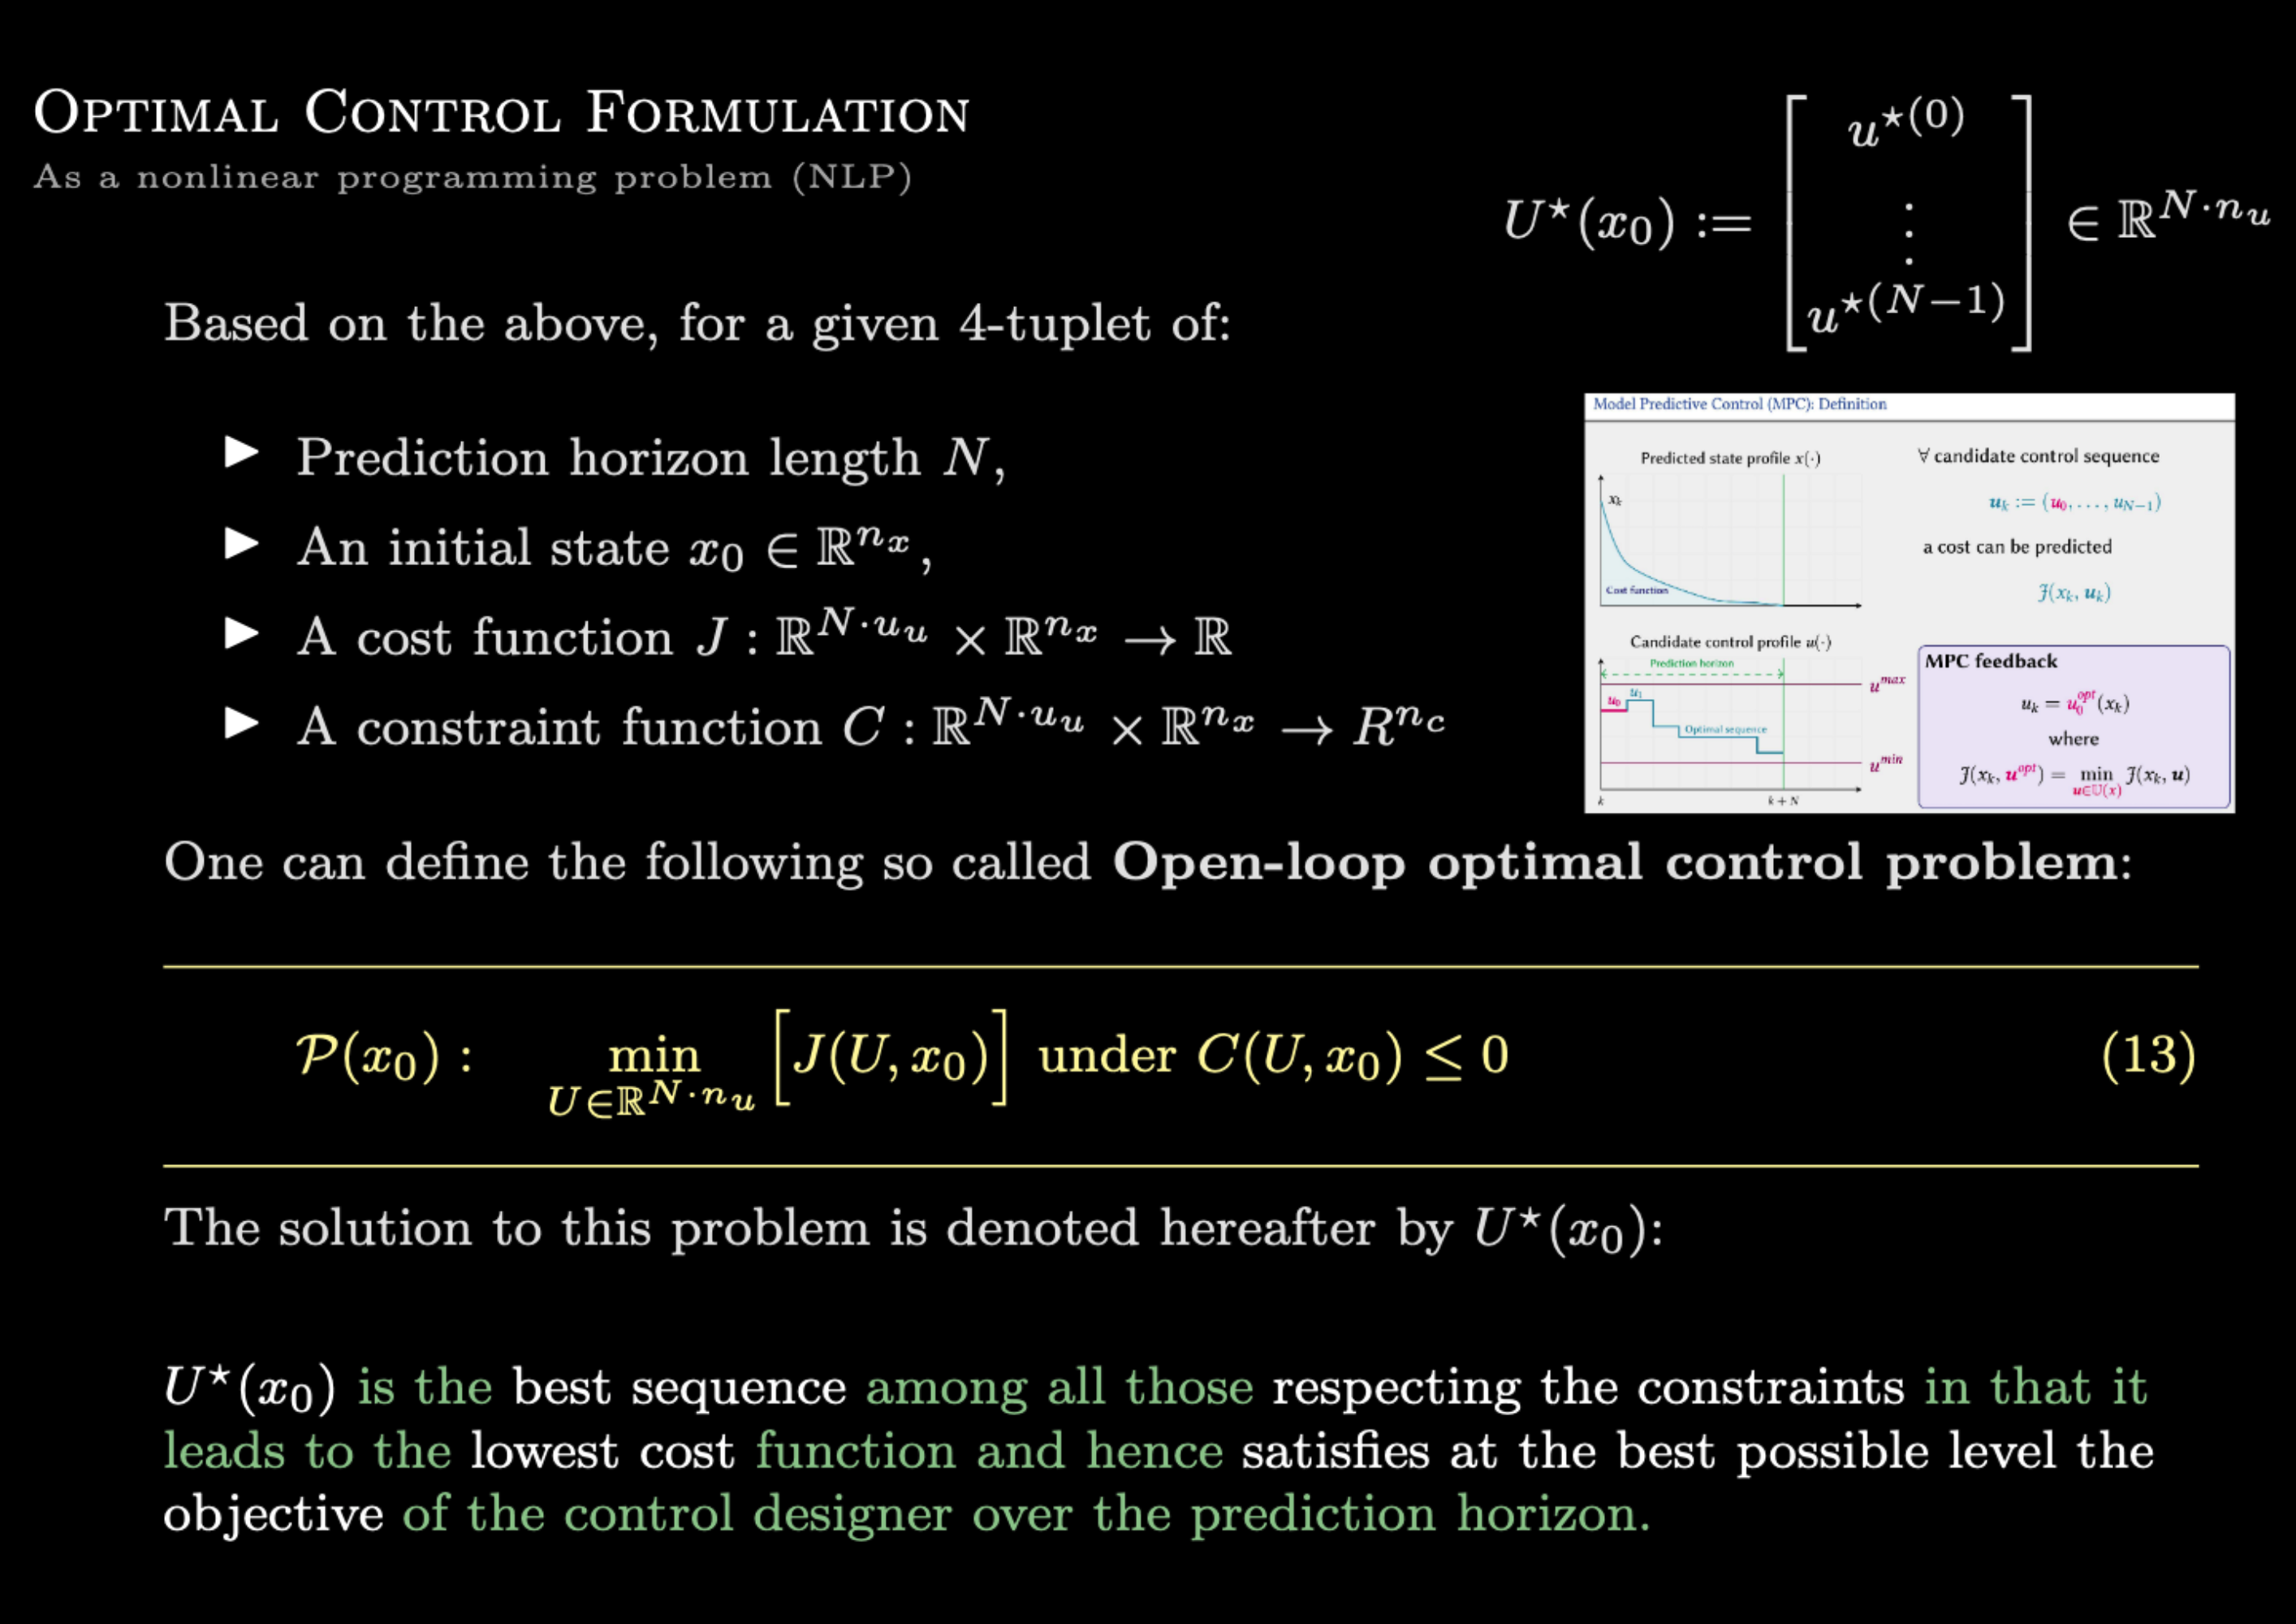

In [3]:
to_keep_in_mind = files_root+"tokeepoptimalformulation.png"
display(Image(to_keep_in_mind, width=width))

[back to toc](#toc)

### Example<a class="anchor" id="formulationExample"></a>

Let us reconsider the PVTOL example and formulate an open-loop optimal control problem based on the previous slides. 

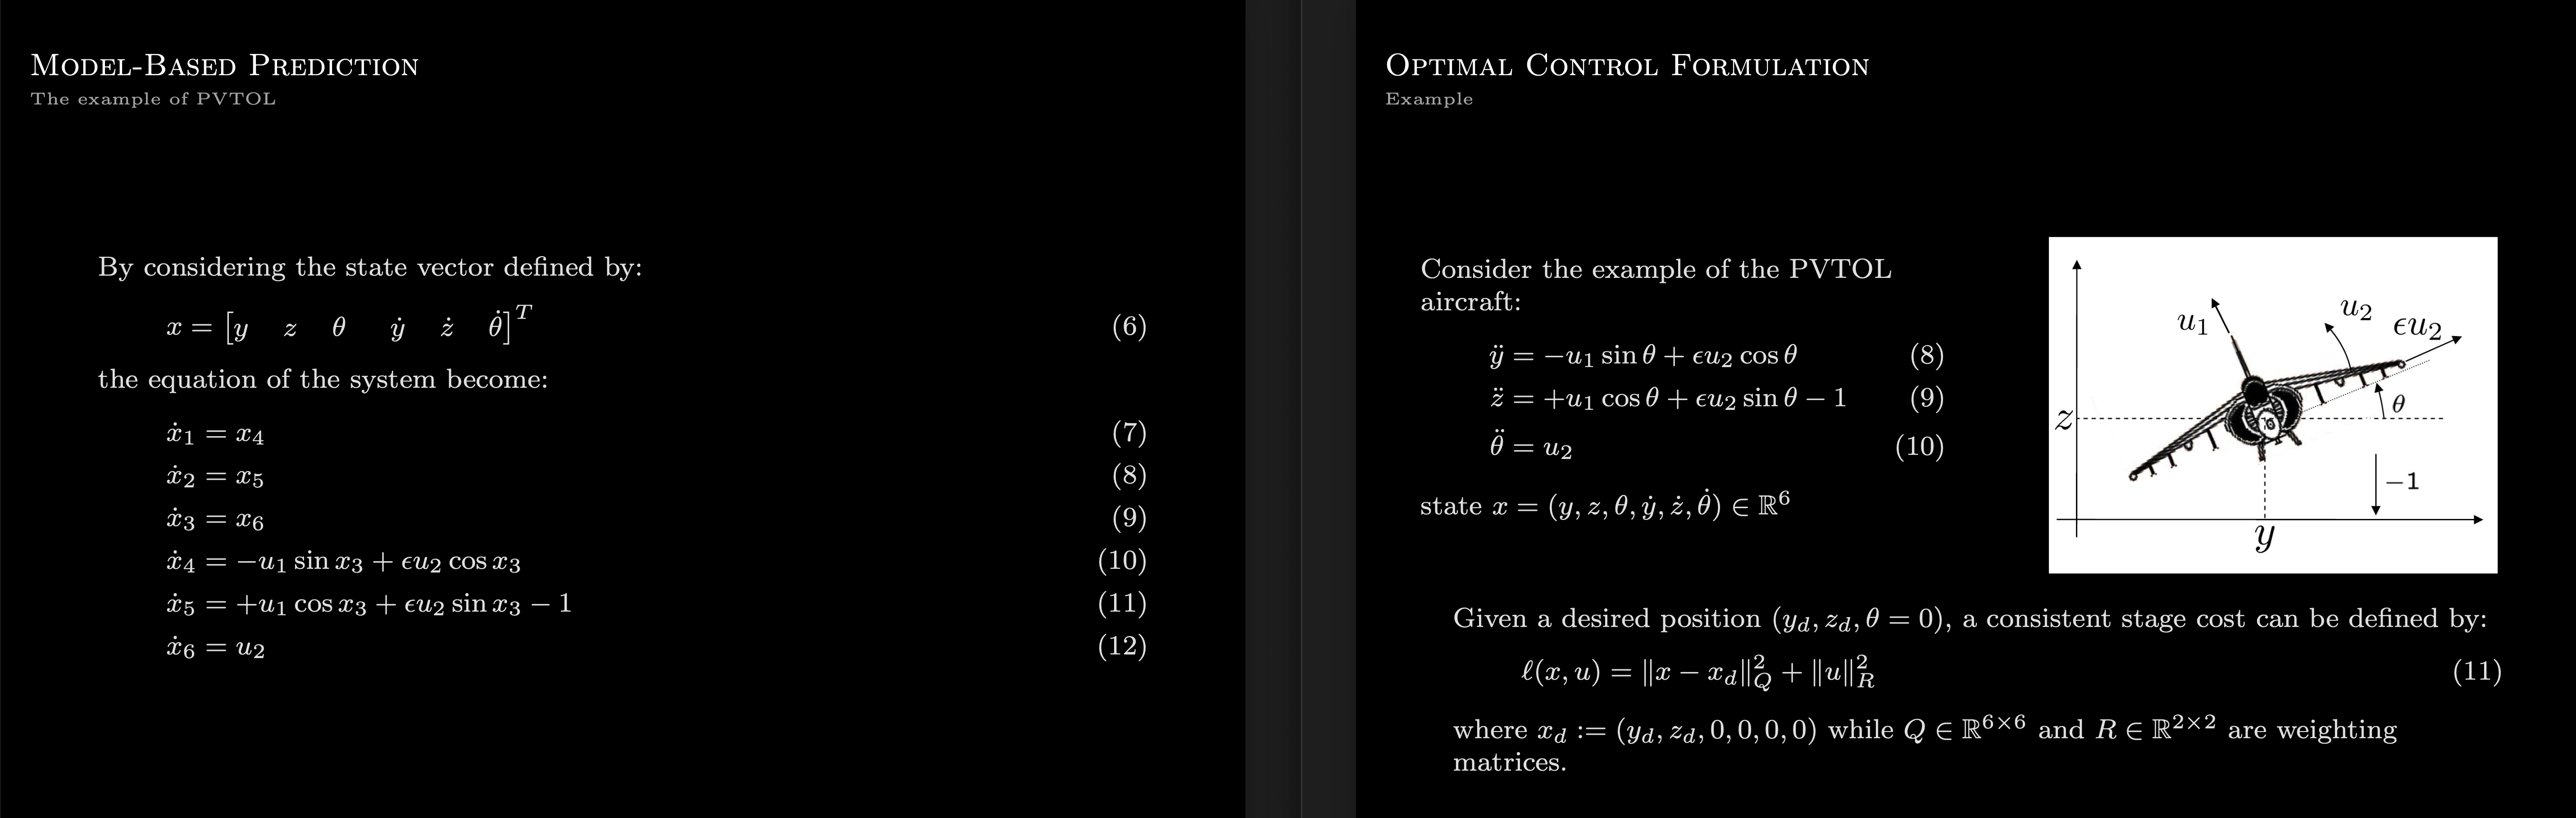

In [4]:
ex = files_root+"ex_formulationoptimalpvtol.png"
display(Image(ex, width=width))

Le us first write function that defines the ODE (with the unknown control as parameter) and another that call the first one in order to simulate the open-loop behaviour for a given candidate sequence of future actions. This is very similar to the job we already did in a previous notebook (see the notebook entitled **Model_Based_Prediction**. However, there is some slight difference since the control is no more given as a parameterized function of time but left free to be optimized in the forthcoming steps. 

[back to toc](#toc)

#### The simulator<a class="anchor" id="simulator"></a>

In [5]:
#--------------- 
# the ODE describing the dynamics of the PVTOL aircraft
# Note that u is no more defined as a functio of time 
# it is to be found by solving the open-loop optimal 
# control problem. 
#--------------- 
def pvtol_ode(x, t, u):
    
    epsilon = 0.04
    
    xdot = np.zeros(6)
    
    xdot[0] = x[3]
    xdot[1] = x[4]
    xdot[2] = x[5]
    xdot[3] = -u[0] * np.sin(x[2])+epsilon * u[1] * np.cos(x[2])
    xdot[4] = u[0] * np.cos(x[2])+epsilon * u[1] * np.sin(x[2])-1
    xdot[5] = u[1]
    #----
    return xdot 
#--------------- 
# Definition of the simulator
#--------------- 
def simulate(U, x0, dt):
    
    t = np.array([i * dt for i in range(len(U)+1)])
    X = [x0]
    for i in range(len(U)):
        t_integ = np.linspace(t[i], t[i]+dt, 3)
        x_integ = odeint(pvtol_ode, X[-1], t_integ, args=(U[i],))
        X += [x_integ[-1,:]]
        
    return t, X

#### The cost function<a class="anchor" id="cost"></a>

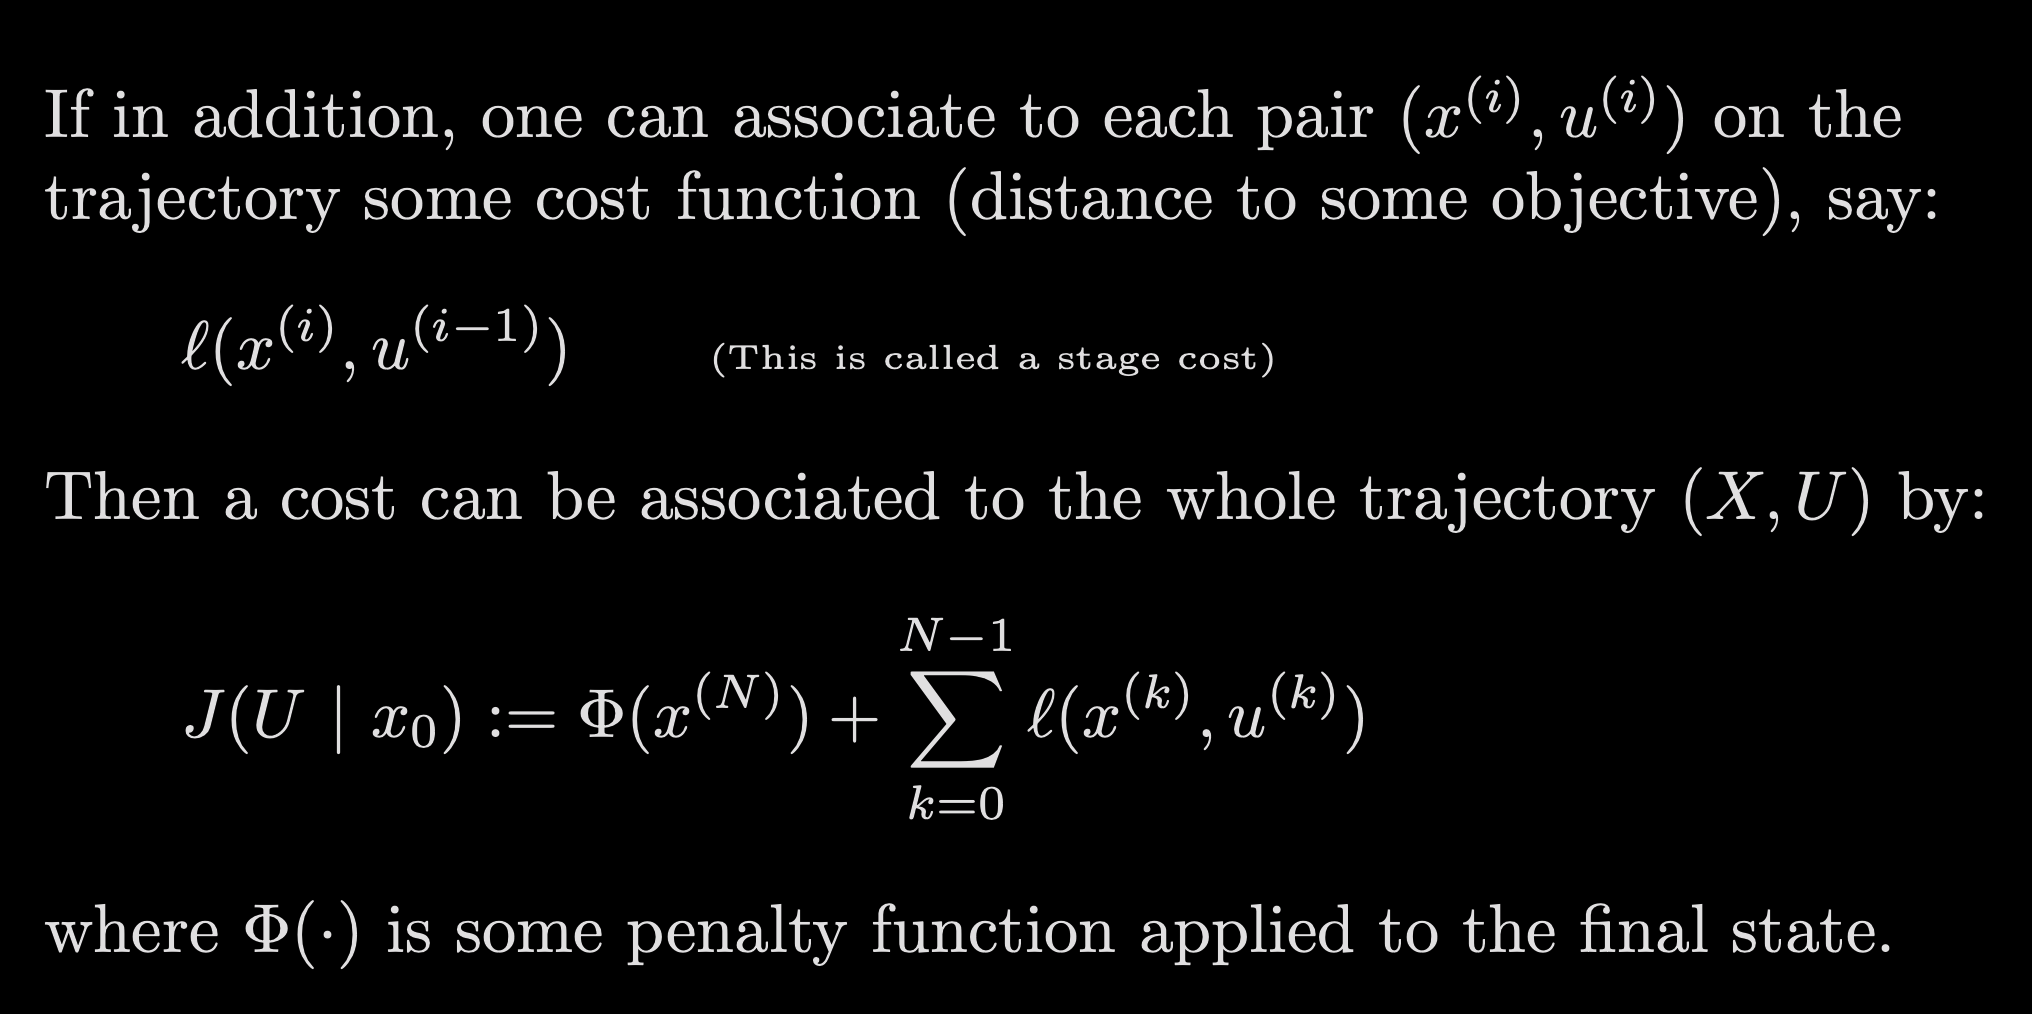

In [6]:
ex = files_root+"sumofell.png"
display(Image(ex, width=width))

In [7]:
#--------------
# class that should contain the paramter of the 
# open-loop optimal control problem 
#--------------
class Context:
    def __init__(self):
        
        self.x0 = None
        self.dt = None
        self.xd = None
        self.ud = None
        self.Q  = None
        self.Qf = None
        self.R  = None
    
def cost(U, c):
    
    t, X = simulate(U, c.x0, c.dt)
    J = 0
    for i in range(len(X)-1):
        x, u = X[i], U[i]
        ex = x-c.xd
        eu = u-c.ud
        J += np.matmul(ex,np.matmul(c.Q, ex))
        J += np.matmul(eu,np.matmul(c.R, eu))
    ef = X[-1]-c.xd    
    J += np.matmul(ef,np.matmul(c.Qf, ef))
    
    return J
 

[back to toc](#toc)

#### Check the call of the cost function

In [8]:
# create an instance of the class context
c = Context()   

# Define the problem paramters 
c.Q = np.diag([1e3, 1e2, 1e2, 1, 1, 1])
c.R = np.diag([1e-1, 1e-1])
c.Qf = 1e1 * c.Q
c.x0 = np.zeros(6)
c.xd = np.array([0.05, 0.05, 0, 0, 0, 0])
c.ud = np.array([1,0])
N = 10
U = [0.1 * np.random.randn(2) for _ in range(N)]
c.dt = 0.2

# Test the cost function definition and evaluate the computation time

print(f'cost = {cost(U,c)}')

# Run several time and take the statistics of cpu-time

Ntrials = 100
cpu = []
for _ in range(Ntrials):
    U = [0.1 * np.random.randn(2) for _ in range(N)]
    t1 = time.time()
    cost(U, c)    
    cpu += [time.time()-t1]

cpu = np.array(cpu)

print(f'Mean cpu = {cpu.mean()}')
print(f'Standard deviation cpu = {cpu.std()}')
print(f'Max cpu = {cpu.max()}')

cost = 5181.503534624585
Mean cpu = 0.002000269889831543
Standard deviation cpu = 0.00028720749656960487
Max cpu = 0.002852201461791992


[back to toc](#toc)

#### The constraints<a class="anchor" id="constraints"></a>

Le us consider the simple saturation constraints on the actuators given by 
$$
\underline u\le u\le \overline u \quad \text{with}\quad \underline u= \begin{bmatrix}
-1\cr -2
\end{bmatrix} \quad \text{and}\quad \overline u= \begin{bmatrix}
2\cr 3
\end{bmatrix}
$$

When the constraints of this type there is no need for a specific constraints function as this bounds can be given when calling the optimizer as it is shown in the next section. 

We can also consider the following saturation constraint on the rate of change of the angle $\theta$ (the 6-th component of the state vector): 

$$
\vert \dot\theta\vert \le 0.1
$$

#### Solving the optimal control problem usinf scipy.optimize<a class="anchor" id="solution"></a>

In [9]:
scipy_opt = "https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html"
display(IFrame(scipy_opt, width=width, height=1000))

#### With only saturation constraints on the input 

In [10]:
# since U should be a vector, we need to define a specific form of the cost function
# our cost function uses U as list 

def vec_2_list(vecU):
    
    N = int(len(vecU)/2)
    U_list = [vecU[i * 2:(i+1) * 2] for i in range(N)]
    return U_list

def cost_for_scipy(U, c):
    return cost(vec_2_list(U), c)
    
U0 = np.zeros(2*N)    
umin = [-1,-2]
umax = [2, 3]
bounds_min = np.array([umin for _ in range(N)]).flatten()
bounds_max = np.array([umax for _ in range(N)]).flatten()
bounds = [(bounds_min[i], bounds_max[i]) for i in range(len(bounds_min))]

#----- Solving the optimal control problem
print(f'initial cost value = {cost_for_scipy(U0,c)}')

t1 = time.time()
res = minimize(fun=cost_for_scipy, x0=U0, args=(c,), 
               method='Powell', 
               options={'disp':True},bounds=bounds)
print(f'final cost value = {cost_for_scipy(res.x,c)}')
print(f'cpu time = {time.time()-t1}')
#---------
# Cheking the optimal solution 
U_opt = vec_2_list(res.x)
t, X = simulate(U_opt, c.x0, c.dt)


initial cost value = 4977.720466846708
Optimization terminated successfully.
         Current function value: 16.706255
         Iterations: 40
         Function evaluations: 12353
final cost value = 16.70625532234836
cpu time = 39.308480978012085


[back to toc](#toc)

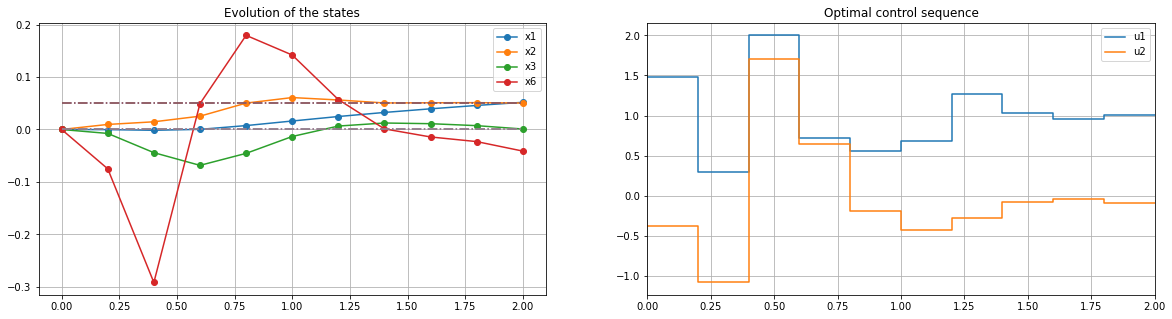

In [11]:
# let us plot the result

X = np.array(X)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
[ax[0].plot(t, X[:,i], '-o', label='x'+str(i+1)) for i in [0,1,2,5]];
[ax[0].plot(t, np.ones(len(t))*c.xd[i], '-.') for i in [0,1,2,5]];
ax[0].legend()
ax[0].grid(True)
ax[0].set_title('Evolution of the states');
#----
U_opt_ = np.array(U_opt)
U_opt_ = np.array([U_opt[0]]+list(U_opt_))
[ax[1].step(t, U_opt_[:,i], label='u'+str(i+1)) for i in range(2)];
ax[1].grid(True)
ax[1].set_title('Optimal control sequence');
ax[1].set_xlim([t.min(), t.max()]);
ax[1].legend();

Note that the computation time for a single solution of the optimal control problem is around 5 sec. This is obviously incompatible with the implementation of MPC with a sampling period lower that 5 sec which is quite obviously the case for the PVTOL system (we cannot leave the aircraft in open-loop diring bunches of 5 sec before we react to change in the state. 

Note that this already long computation time corresponds to the case where only saturation on the control input actuator is imposed. Below, we will see that the time would be much longer should state constraints are to enforced. 

#### With saturation constraint on input and state

Here we need to define a constraint function since enforcing the constraints on the state trajectory need the future trajectory of the state to be computed for any value of the decision variable $U$

In [12]:
# Definition of the constraints function for scipy's minimizer call 
def constraints_for_scipy(U, c):
    
    t, X = simulate(vec_2_list(U), c.x0, c.dt)
    g = []
    for x in X:
        g += [abs(x[5])-c.dthetadt_max]        
    return np.array(g).max()
    
c.dthetadt_max = 0.1   
constraints_for_scipy(res.x, c)    

0.19146944983386519

In [13]:
# Define the constraints dictionary for scipy.optimize

cons = ({'type': 'ineq', 'fun': constraints_for_scipy, 'args':(c,)})

#----- Solving the optimal control problem

print(f'initial cost value = {cost_for_scipy(U0,c)}')
t1 = time.time()
res = minimize(fun=cost_for_scipy, x0=U0, args=(c,), 
               method='trust-constr', 
               options={'disp':True},
               bounds=bounds, 
               constraints=cons)
print(f'cpu time = {time.time()-t1}')
#---------

print(f'final cost value = {cost_for_scipy(res.x,c)}')

U_opt_constr = vec_2_list(res.x)
t1 = time.time()
t, X = simulate(U_opt_constr, c.x0, c.dt)
print(f'cpu time = {time.time()-t1}')

initial cost value = 4977.720466846708


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 21609, CG iterations: 16830, optimality: 6.20e-05, constraint violation: 0.00e+00, execution time: 1.8e+02 s.
cpu time = 175.80397486686707
final cost value = 14.672320284350063
cpu time = 0.004350900650024414


[back to toc](#toc)

In [14]:
constraints_for_scipy(res.x, c)   

0.23896982367673017

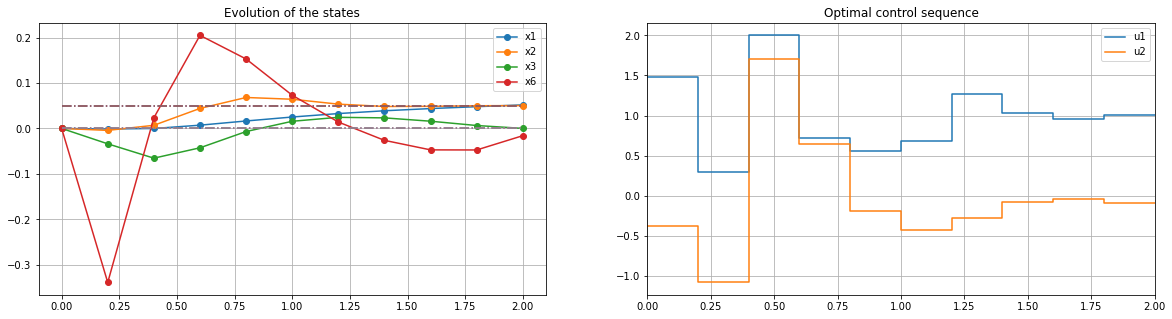

In [15]:
X = np.array(X)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
[ax[0].plot(t, X[:,i], '-o', label='x'+str(i+1)) for i in [0,1,2,5]];
[ax[0].plot(t, np.ones(len(t))*c.xd[i], '-.') for i in [0,1,2,5]];
ax[0].legend()
ax[0].grid(True)
ax[0].set_title('Evolution of the states');
#----
U_opt_ = np.array(U_opt)
U_opt_ = np.array([U_opt[0]]+list(U_opt_))
[ax[1].step(t, U_opt_[:,i], label='u'+str(i+1)) for i in range(2)];
ax[1].grid(True)
ax[1].set_title('Optimal control sequence');
ax[1].set_xlim([t.min(), t.max()]);
ax[1].legend();


Note that the constraints is not even satisfied afer 3 minutes of computation ! we definitively need something more serious!!

## Checkpoint 3

1. What are the ingredients of a constrained optimization problem?
2. What is the impact of introducing constraints on the computation time when solving an optimal control problem?
3. In an optimal control problem, what is ultimately the quantity one would like to compute?
4. To which one of the ingredients invoked in question 1. the feasibility issue is related?